In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
from math import *

In [62]:
#read data
mat = scipy.io.loadmat('RadarMeasurements.mat')

data1 = mat['z1']
data2 = mat['z2']

data1_arr = np.zeros((data1.shape[1], 2))
data1_arr[:,0] = data1[0]
data1_arr[:,1] = data1[1]

data2_arr = np.zeros((data2.shape[1], 2))
data2_arr[:,0] = data2[0]
data2_arr[:,1] = data2[1]

Text(0, 0.5, 'θ')

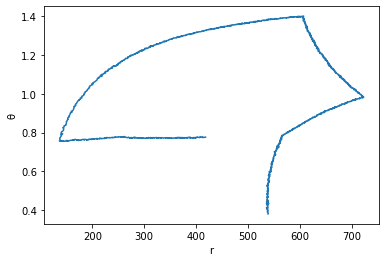

In [63]:
f2 = plt.figure()
plt.plot(data1_arr[:,0], data1_arr[:,1], label='linear')
plt.xlabel('r')
plt.ylabel('θ')

Text(0, 0.5, 'θ')

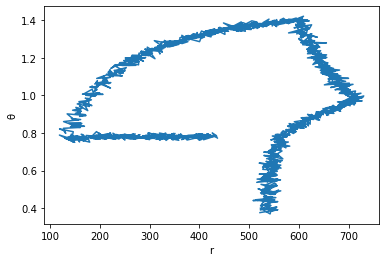

In [64]:
f2 = plt.figure()
plt.plot(data2_arr[:,0], data2_arr[:,1], label='linear')
plt.xlabel('r')
plt.ylabel('θ')

In [65]:
def apply_ekf(z, var_r):
    # initialize variables
    data_size = z.shape[0]
    
    T = 0.5  # [s] Sampling time interval
    R1 = float(var_r) 
    R2 = float(0.001)
    R = np.array([[R1,0],[0,R2]])
    
    k = np.zeros((data_size+1,4,2))
    G = np.identity(4)

    p = np.zeros((data_size+1,4,4))
    p[0]=np.array([[R1,R1/T,0,0],
                   [R1/T,2*R1/T**2,0,0],
                   [0,0,R2,R2/T],
                   [0,0,R2/T,2*R2/T**2]])

    H = np.array([[1,0],
                  [0,1]])

    A = np.array([[1, 0, 0, 0], 
                  [0, 0, 0, 0], 
                  [0, 0, 1, 0], 
                  [0, 0, 0, 0.0]], dtype=float)  
    
    # Equation(11)
    # 1 is variance of the process noise
    Q = 1*np.array([[T**3/3,T**2/2,0,0],
                    [T**2/2,T,0,0],
                    [0,0,T**3/3,T**2/2],
                    [0,0,T**2/2,T]])
    
    x = np.zeros((data_size, 4))
    x[0, :] = [500, 60 , 200, 42] # initial state[500; 60; 200; 42]
    NIS = np.zeros(data_size)    
    for i in range(0,data_size-1):
        # Here PX and Py are the coordinates for distance .
        px=x[i,0]
        py=x[i,2]
        # The Jacobian 𝐶(k)
        c11=px/sqrt(px**2+py**2)
        c13=py/sqrt(px**2+py**2)
        c21=(-py/(px**2))/(1+(py/px)**2)
        c23=(1/px)/(1+(py/px)**2)
        C=np.array([[c11,0,c13,0],
                    [c21,0,c23,0]])
        # Eq(3) or Eq(14)
        _x = A.dot(x[i])
        # (4) 
        p_ = A.dot(p[i]).dot(A.T) + G.T.dot(Q).dot(G)
        # (5)
        k[i] = p_.dot(C.T).dot(np.linalg.inv(C.dot(p_).dot(C.T) + H.dot(R).dot(H.T)))
        # (6)
        x[i+1] = _x + k[i].dot(z[i]-np.array([sqrt(px**2+py**2),np.arctan2(py,px)]))
        # (7)
        p[i+1] = (np.identity(4)-np.dot(k[i],C)).dot(p_)
        # NIS section
        S = np.linalg.inv(C.dot(p_).dot(C.T)+H.dot(R).dot(H.T))
        z_temp = z[i]-C.dot(x[i+1])
        NIS[i] = z_temp.dot(S).dot(z_temp.T)
     
    NIS[:]=NIS[:] - NIS.mean()
    return x,p,k,NIS

## apply EKF for Z1

In [66]:
[x,p,k,NIS] = apply_ekf(data1_arr,'1')

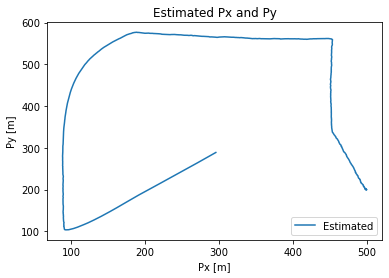

In [67]:
f1 = plt.figure()
plt.plot(x[:, 0], x[:, 2], label='Estimated')
plt.xlabel('Px [m]')
plt.ylabel('Py [m]')
plt.title('Estimated Px and Py')
plt.legend() 
plt.show()

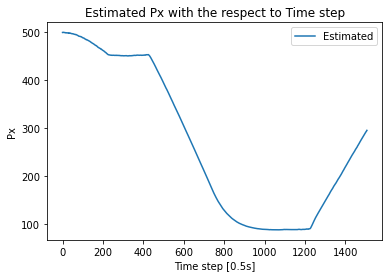

In [68]:
plt.plot(x[:, 0], label='Estimated')
plt.xlabel('Time step [0.5s]') 
plt.ylabel('Px')
plt.title('Estimated Px with the respect to Time step')
plt.legend() 
plt.show()

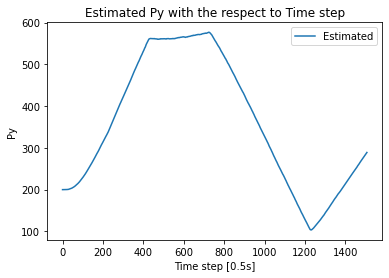

In [69]:
plt.plot(x[:,2],label='Estimated')
plt.xlabel('Time step [0.5s]') 
plt.ylabel('Py')
plt.title('Estimated Py with the respect to Time step')
plt.legend() 
plt.show()

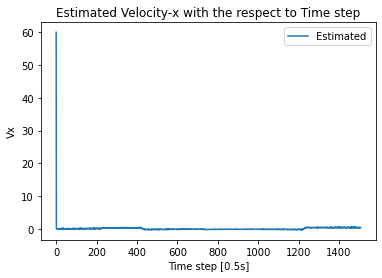

In [70]:
plt.plot(x[:,1], label='Estimated')
plt.xlabel('Time step [0.5s]') 
plt.ylabel('Vx')
plt.title('Estimated Velocity-x with the respect to Time step')
plt.legend() 
plt.show()

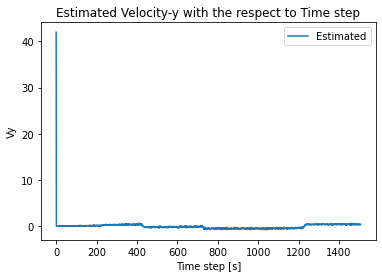

In [71]:
plt.plot(x[:,3],label='Estimated')
plt.xlabel('Time step [s]') 
plt.ylabel('Vy')
plt.title('Estimated Velocity-y with the respect to Time step')
plt.legend() 
plt.show()

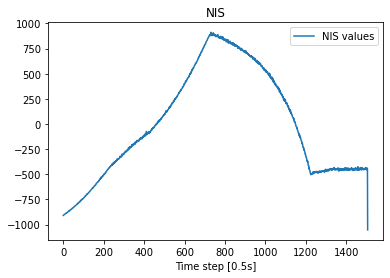

In [72]:
plt.plot(NIS,label='NIS values')
plt.title('NIS')
plt.xlabel('Time step [0.5s]')
plt.legend() 
plt.show()

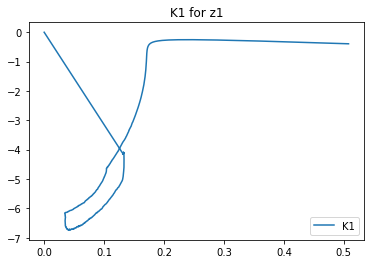

In [73]:
plt.plot(k[:,0,0], k[:,0,1],label='K1')
plt.title('K1 for z1')
plt.legend() 
plt.show()

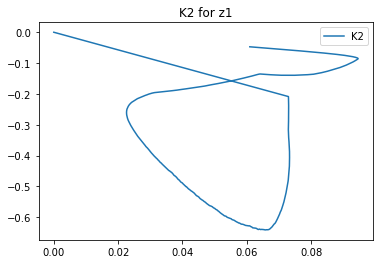

In [74]:
plt.plot(k[:,1,0], k[:,1,1],label='K2')
plt.title('K2 for z1')
plt.legend() 
plt.show()

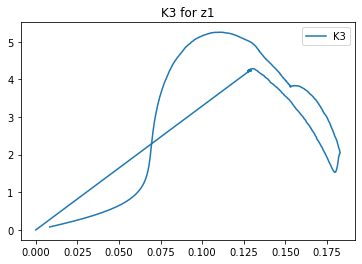

In [75]:
plt.plot(k[:,2,0], k[:,2,1],label='K3')
plt.title('K3 for z1')
plt.legend() 
plt.show()

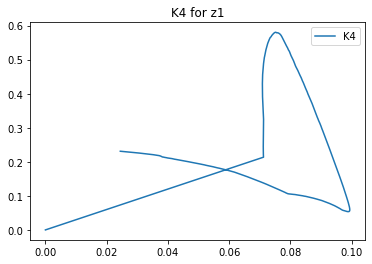

In [76]:
plt.plot(k[:,3,0], k[:,3,1],label='K4')
plt.title('K4 for z1')
plt.legend() 
plt.show()

## apply EKF for Z2

In [77]:
[x,p,k,NIS] = apply_ekf(data2_arr,'100')

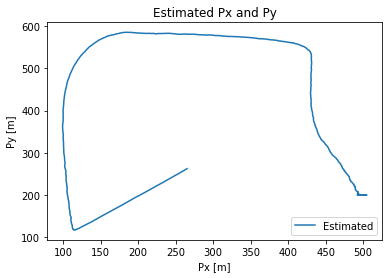

In [78]:
f1 = plt.figure()
plt.plot(x[:, 0], x[:, 2], label='Estimated')
plt.xlabel('Px [m]')
plt.ylabel('Py [m]')
plt.title('Estimated Px and Py')
plt.legend() 
plt.show()

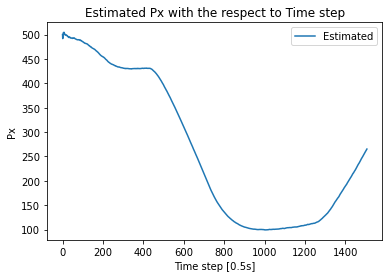

In [79]:
plt.plot(x[:, 0], label='Estimated')
plt.xlabel('Time step [0.5s]') 
plt.ylabel('Px')
plt.title('Estimated Px with the respect to Time step')
plt.legend() 
plt.show()

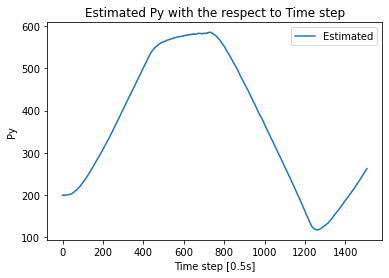

In [80]:
plt.plot(x[:,2],label='Estimated')
plt.xlabel('Time step [0.5s]') 
plt.ylabel('Py')
plt.title('Estimated Py with the respect to Time step')
plt.legend() 
plt.show()

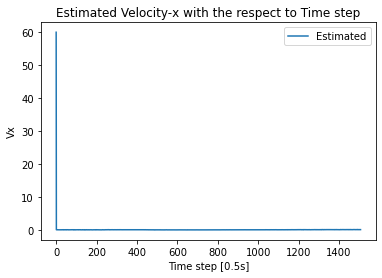

In [81]:
plt.plot(x[:,1], label='Estimated')
plt.xlabel('Time step [0.5s]') 
plt.ylabel('Vx')
plt.title('Estimated Velocity-x with the respect to Time step')
plt.legend() 
plt.show()

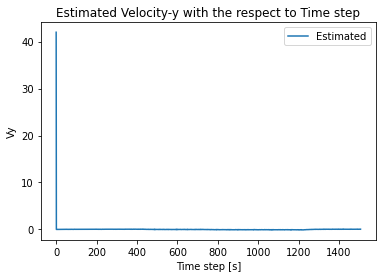

In [82]:
plt.plot(x[:,3],label='Estimated')
plt.xlabel('Time step [s]') 
plt.ylabel('Vy')
plt.title('Estimated Velocity-y with the respect to Time step')
plt.legend() 
plt.show()

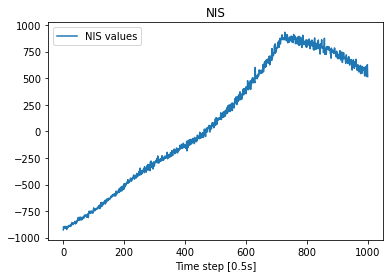

In [83]:
plt.plot(NIS[0:1000],label='NIS values')
plt.title('NIS')
plt.xlabel('Time step [0.5s]')
plt.legend() 
plt.show()

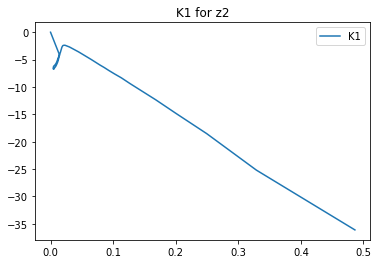

In [84]:
plt.plot(k[:,0,0], k[:,0,1],label='K1')
plt.title('K1 for z2')
plt.legend() 
plt.show()

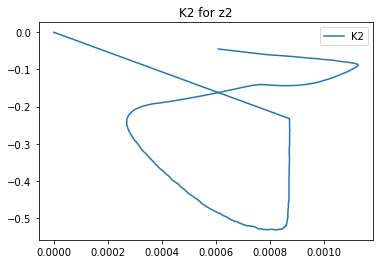

In [85]:
plt.plot(k[:,1,0], k[:,1,1],label='K2')
plt.title('K2 for z2')
plt.legend() 
plt.show()

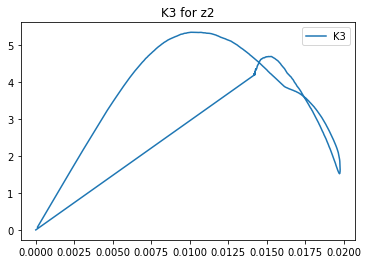

In [86]:
plt.plot(k[:,2,0], k[:,2,1],label='K3')
plt.title('K3 for z2')
plt.legend() 
plt.show()

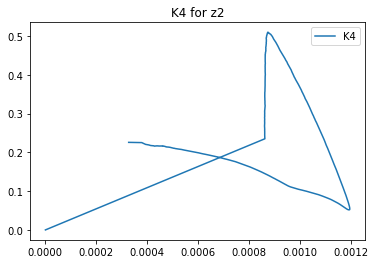

In [87]:
plt.plot(k[:,3,0], k[:,3,1],label='K4')
plt.title('K4 for z2')
plt.legend() 
plt.show()